In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *

import numpy as np

dim=125
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

FD_StencilMat=np.zeros((dim,dim))
b = np.ones(dim-1)
c = -2*np.ones(dim)
np.fill_diagonal(FD_StencilMat[1:], b)
np.fill_diagonal(FD_StencilMat[:,1:], b)
np.fill_diagonal(FD_StencilMat, c)
A=FD_StencilMat
A=np.asmatrix(A)
# A = mk_laplace_1d(dim)
AType='1D Laplacian'

retrain_freq=1
e1 = 1e-4
e2 = 1e-7
nmax_iter = 50
restart   = 64

sigma=0.02
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =500
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("Benchmark 125 dim problem using op func. ")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-09 21:03:29 [INFO] <ipython-input-4-f8644901a075> 2 - Benchmark 125 dim problem using op func. 


In [5]:
# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,blist,reslist,Err_list,refine):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *



ML_GMRES_Time_list=[] 
Err_list=[]


trainTime_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_time_list=[]

run_time_ML_listP1=[]
run_time_ML_listP2=[]

GmresRunTimeOriginal=[]
GmresRunTimeOriginal_2=[]


debug=True

blist=[]
reslist=[]

refine1=False
refine2=True

for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
#     b=Gauss_pdf(x,loc,sigma)
    b=(np.sin(ProbIdx)+.0001)*np.maximum(x-loc,0)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,blist,reslist,Err_list,refine1)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    trainTime_list.append(OutList1[2])
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    

#     ML_Out2,run_time2_ML=GMRES_timed(A, b/b_norm, Out[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,blist,reslist,Err_list,refine2)  # normalize b for optimal NN performance.
    Out=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]
    
    run_time_ML_listP1.append(run_time1_ML)
    run_time_ML_listP2.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
    GmresRunTimeOriginal.append(run_time1)
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    run_time_list.append(run_time1+run_time2)
    GmresRunTimeOriginal_2.append(run_time2)

    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
Final loss: 6693.67041015625
parameters 31250
Initial Training
2
size 52
0.22909198278068116 0.8873242424929298
0.2466648340000006 0.3820650660000027 0.22909198278068116 0.8055194376078241
0.2466648340000006 0.3820650660000027 0.22909198278068116 0.8055194376078241
3
size 52
0.6374933855324927 0.8873242424929298
0.2436582149999964 0.341894359500003 0.6374933855324927 0.5108212027085911
0.2436582149999964 0.341894359500003 0.6374933855324927 0.5108212027085911
4
size 52
0.5921703075612486 0.8873242424929298
0.28326675799999634 0.3091489780000008 0.5921703075612486 0.5530452636498916
0.28326675799999634 0.3091489780000008 0.5921703075612486 0.5530452636498916
5
size 52
0.5827968099149242 0.8873242424929298
0.5545723460000005 0.2578632689999978 0.5827968099149242 0.48625189195814084
0.5545723460000005 0.2578632689999978 0.5827968099149242 0.48625189195814084
6
size 52
0.4126120683188271 0.8873242424929298
0.3294494419999978 0.33204053824999846 0.4126120683188271 0.5103881214473367
0.3

0.3132703539999966 0.31200356532000567 0.09852576088132353 0.3142607392690689
0.3132703539999966 0.31200356532000567 0.09852576088132353 0.3142607392690689
39
size 52
0.43926534731218364 0.8873242424929298
0.31667676700001834 0.3073961160400063 0.43926534731218364 0.2893046941031962
0.31667676700001834 0.3073961160400063 0.43926534731218364 0.2893046941031962
InnerProd [[1.0000004  0.97123677 0.8965166 ]
 [0.97123677 1.         0.9631906 ]
 [0.8965166  0.9631906  1.        ]]
retraining
1
Final loss: 3263.072509765625
parameters 31250
40
size 52
0.06752548513938503 0.8873242424929298
0.21274773800001867 0.3133316882800068 0.06752548513938503 0.30430452034491823
0.21274773800001867 0.3133316882800068 0.06752548513938503 0.30430452034491823
41
size 52
0.03115770147193441 0.8873242424929298
0.19472057699999823 0.30242243364000726 0.03115770147193441 0.29270705068470626
0.19472057699999823 0.30242243364000726 0.03115770147193441 0.29270705068470626
42
size 52
0.07629109211510837 0.88732424

0.230582437999999 0.23950188128000263 0.11876405721570941 0.11455434283878843
74
size 52
0.01223656742583595 0.8873242424929298
0.10676252600001135 0.2357268200400017 0.01223656742583595 0.11158279171479962
0.10676252600001135 0.2357268200400017 0.01223656742583595 0.11158279171479962
75
size 52
0.052264869247257574 0.8873242424929298
0.16760979000002862 0.2289866708400018 0.052264869247257574 0.10787158663513959
0.16760979000002862 0.2289866708400018 0.052264869247257574 0.10787158663513959
76
size 52
0.2976480183515174 0.8873242424929298
0.20513797000000977 0.22629862280000224 0.2976480183515174 0.10665430884704918
0.20513797000000977 0.22629862280000224 0.2976480183515174 0.10665430884704918
77
size 52
0.022297815916716552 0.8873242424929298
0.1799455089999924 0.22331852356000353 0.022297815916716552 0.11556173265232424
0.1799455089999924 0.22331852356000353 0.022297815916716552 0.11556173265232424
78
size 52
0.08111915707910267 0.8873242424929298
0.19998040199999423 0.2163448471200

0.25499404799995773 0.16704047452000167 0.14803360116036918 0.07255444857881384
111
size 52
0.08960985147571127 0.8873242424929298
0.14797901399998636 0.16892647275999934 0.08960985147571127 0.07579304576358725
0.14797901399998636 0.16892647275999934 0.08960985147571127 0.07579304576358725
112
size 52
0.10388660975427892 0.8873242424929298
0.24067466799999693 0.16978633087999925 0.10388660975427892 0.07534544272752443
0.24067466799999693 0.16978633087999925 0.10388660975427892 0.07534544272752443
InnerProd [[ 0.9999999  -0.99810016 -0.96896887]
 [-0.99810016  0.99999994  0.9808629 ]
 [-0.96896887  0.9808629   1.        ]]
retraining
1
Final loss: 584.18603515625
parameters 31250
113
size 52
0.16526524111857505 0.8873242424929298
0.24406499400004122 0.16962292399999795 0.16526524111857505 0.07628253707603104
0.24406499400004122 0.16962292399999795 0.16526524111857505 0.07628253707603104
114
size 52
0.21634371316163484 0.8873242424929298
0.19938231800000494 0.17253870519999964 0.21634371

0.17777643900001294 0.17181419384000038 0.0849803266912748 0.06118329586971148
144
size 52
0.04421489155725371 0.8873242424929298
0.10989691500003573 0.17312320451999766 0.04421489155725371 0.06275492993440564
0.10989691500003573 0.17312320451999766 0.04421489155725371 0.06275492993440564
145
size 52
0.07995351160929141 0.8873242424929298
0.1485042289999683 0.1698638068399987 0.07995351160929141 0.06274494021023018
0.1485042289999683 0.1698638068399987 0.07995351160929141 0.06274494021023018
146
size 52
0.03867575330390255 0.8873242424929298
0.10729365100007726 0.16702856727999915 0.03867575330390255 0.06462109161893223
0.10729365100007726 0.16702856727999915 0.03867575330390255 0.06462109161893223
147
size 52
0.021035161608536752 0.8873242424929298
0.18891673799998898 0.1656396158000007 0.021035161608536752 0.06396829066384296
0.18891673799998898 0.1656396158000007 0.021035161608536752 0.06396829066384296
148
size 52
0.12164899680916179 0.8873242424929298
0.2201476970000158 0.16933789

0.14235729799997898 0.156041127160006 0.0275430310755745 0.04248878192223633
179
size 52
0.02624844179126293 0.8873242424929298
0.07025153000006412 0.15319599948000814 0.02624844179126293 0.04019524633563207
0.07025153000006412 0.15319599948000814 0.02624844179126293 0.04019524633563207
180
size 52
0.014053117435101393 0.8873242424929298
0.09223472600001514 0.15208204172000933 0.014053117435101393 0.03985445415944202
0.09223472600001514 0.15208204172000933 0.014053117435101393 0.03985445415944202
181
size 52
0.03725131792740463 0.8873242424929298
0.10436399799993978 0.1520733188000122 0.03725131792740463 0.039969086860230714
0.10436399799993978 0.1520733188000122 0.03725131792740463 0.039969086860230714
182
size 52
0.06746208016273889 0.8873242424929298
0.12448564599992551 0.15063478280001164 0.06746208016273889 0.04067847848303126
0.12448564599992551 0.15063478280001164 0.06746208016273889 0.04067847848303126
183
size 52
0.04346266421162754 0.8873242424929298
0.1812619460000633 0.1495

214
size 52
0.03934737454492957 0.8873242424929298
0.10153783800001293 0.1263368905200059 0.03934737454492957 0.03782672860665774
0.10153783800001293 0.1263368905200059 0.03934737454492957 0.03782672860665774
215
size 52
0.059908686847303286 0.8873242424929298
0.15051089999997203 0.12527188924000712 0.059908686847303286 0.03696694106082877
0.15051089999997203 0.12527188924000712 0.059908686847303286 0.03696694106082877
216
size 52
0.04815564459889443 0.8873242424929298
0.1815089749999288 0.12693258952000633 0.04815564459889443 0.03804983635292188
0.1815089749999288 0.12693258952000633 0.04815564459889443 0.03804983635292188
217
size 52
0.023183978881630502 0.8873242424929298
0.12215288999993845 0.126838452840002 0.023183978881630502 0.03754804602221349
0.12215288999993845 0.126838452840002 0.023183978881630502 0.03754804602221349
218
size 52
0.011797171427945728 0.8873242424929298
0.10312671400004092 0.12800001019999854 0.011797171427945728 0.037569578069903325
0.10312671400004092 0.12

0.056646109999974215 0.14471434567999494 0.011359494887453341 0.04147239758994737
248
size 52
0.011460116842925834 0.8873242424929298
0.0819210810000186 0.1375056416399957 0.011460116842925834 0.04041846508098603
0.0819210810000186 0.1375056416399957 0.011460116842925834 0.04041846508098603
249
size 52
0.007985584889660592 0.8873242424929298
0.10268272600001183 0.13409129719999782 0.007985584889660592 0.039182206314719734
0.10268272600001183 0.13409129719999782 0.007985584889660592 0.039182206314719734
250
size 52
0.017324112375172358 0.8873242424929298
0.05460519899997962 0.13240135115999693 0.017324112375172358 0.038843600037390284
0.05460519899997962 0.13240135115999693 0.017324112375172358 0.038843600037390284
251
size 52
0.0772062018261257 0.8873242424929298
0.20510787699993216 0.12786530819999825 0.0772062018261257 0.03806773211872828
0.20510787699993216 0.12786530819999825 0.0772062018261257 0.03806773211872828
252
size 52
0.031970213686382275 0.8873242424929298
0.17087970399995

281
size 52
0.01412701866407049 0.8873242424929298
0.08002515900011531 0.12089133927999228 0.01412701866407049 0.02973588327546951
0.08002515900011531 0.12089133927999228 0.01412701866407049 0.02973588327546951
282
size 52
0.022239597702747797 0.8873242424929298
0.05430565899996509 0.11858246927999516 0.022239597702747797 0.029197496405427226
0.05430565899996509 0.11858246927999516 0.022239597702747797 0.029197496405427226
283
size 52
0.009284234902443119 0.8873242424929298
0.0690109880001728 0.11653387863999341 0.009284234902443119 0.029112355126262934
0.0690109880001728 0.11653387863999341 0.009284234902443119 0.029112355126262934
284
size 52
0.02197491174803565 0.8873242424929298
0.09636958500004766 0.11607464728000196 0.02197491174803565 0.028991317508423528
0.09636958500004766 0.11607464728000196 0.02197491174803565 0.028991317508423528
285
size 52
0.02174000932429051 0.8873242424929298
0.10758140699999785 0.1165626900000052 0.02174000932429051 0.027383138401423958
0.1075814069999

316
size 52
0.016886010411495893 0.8873242424929298
0.054850275000035253 0.10287934639998639 0.016886010411495893 0.02066342287379935
0.054850275000035253 0.10287934639998639 0.016886010411495893 0.02066342287379935
317
size 52
0.00671333787350365 0.8873242424929298
0.06798631100014063 0.09829203863999282 0.00671333787350365 0.019906528518110474
0.06798631100014063 0.09829203863999282 0.00671333787350365 0.019906528518110474
318
size 52
0.028612805512807045 0.8873242424929298
0.08528638400002819 0.09696182703999512 0.028612805512807045 0.019299881842635352
0.08528638400002819 0.09696182703999512 0.028612805512807045 0.019299881842635352
319
size 52
0.010755436331366615 0.8873242424929298
0.07817912699988483 0.09559721275999436 0.010755436331366615 0.019645775846894184
0.07817912699988483 0.09559721275999436 0.010755436331366615 0.019645775846894184
320
size 52
0.03133450776610912 0.8873242424929298
0.11723765400006414 0.09455606703999365 0.03133450776610912 0.019209058602487124
0.11723

350
size 52
0.020592567366309857 0.8873242424929298
0.17060326700016049 0.09404351384004257 0.020592567366309857 0.02253840552027569
0.17060326700016049 0.09404351384004257 0.020592567366309857 0.02253840552027569
351
size 52
0.02409625182413331 0.8873242424929298
0.10196535299996867 0.09868702216004749 0.02409625182413331 0.02236248495218515
0.10196535299996867 0.09868702216004749 0.02409625182413331 0.02236248495218515
352
size 52
0.01812706831149487 0.8873242424929298
0.05854632099999435 0.09858449764004945 0.01812706831149487 0.022594894863504234
0.05854632099999435 0.09858449764004945 0.01812706831149487 0.022594894863504234
353
size 52
0.03686139262429166 0.8873242424929298
0.10599538499991468 0.09771974680004859 0.03686139262429166 0.022249043744599514
0.10599538499991468 0.09771974680004859 0.03686139262429166 0.022249043744599514
InnerProd [[ 1.0000001 -0.966906  -0.9822032]
 [-0.966906   1.0000001  0.9970265]
 [-0.9822032  0.9970265  1.0000001]]
retraining
1
Final loss: 86.26

Final loss: 79.34779357910156
parameters 31250
385
size 52
0.016507992845469985 0.8873242424929298
0.05916894099982528 0.07881131992002338 0.016507992845469985 0.020057296871298615
0.05916894099982528 0.07881131992002338 0.016507992845469985 0.020057296871298615
386
size 52
0.013277964888633153 0.8873242424929298
0.06793992400002935 0.07714006436001 0.013277964888633153 0.019798643365878048
0.06793992400002935 0.07714006436001 0.013277964888633153 0.019798643365878048
387
size 52
0.020655597331732507 0.8873242424929298
0.14632957899993926 0.07526821232001567 0.020655597331732507 0.01965660936065641
0.14632957899993926 0.07526821232001567 0.020655597331732507 0.01965660936065641
388
size 52
0.02296310582729456 0.8873242424929298
0.10139615299999605 0.079017389920009 0.02296310582729456 0.019981646659426616
0.10139615299999605 0.079017389920009 0.02296310582729456 0.019981646659426616
389
size 52
0.00802907878373604 0.8873242424929298
0.058563807000155066 0.08094673036000131 0.0080290787

0.13573574499991992 0.0846855850799784 0.0165716240018838 0.015889246618326733
420
size 52
0.0294769105256371 0.8873242424929298
0.10251267099988581 0.08602695815997322 0.0294769105256371 0.016129989378332366
0.10251267099988581 0.08602695815997322 0.0294769105256371 0.016129989378332366
421
size 52
0.01379474499241847 0.8873242424929298
0.058183350000035716 0.08664980475996345 0.01379474499241847 0.016341513751257242
0.058183350000035716 0.08664980475996345 0.01379474499241847 0.016341513751257242
422
size 52
0.008397142574197035 0.8873242424929298
0.10236438300012196 0.0849084865599707 0.008397142574197035 0.015728302385443933
0.10236438300012196 0.0849084865599707 0.008397142574197035 0.015728302385443933
InnerProd [[ 0.99999994 -0.9979457  -0.992228  ]
 [-0.9979457   0.99999994  0.982792  ]
 [-0.992228    0.982792    1.        ]]
retraining
1
Final loss: 67.06218719482422
parameters 31250
423
size 52
0.025650995169171575 0.8873242424929298
0.06799152999997204 0.08585085163997974 0.

0.08117014499998731 0.08500861368001096 0.014785713255402457 0.018207479020727616
456
size 52
0.017454126603416643 0.8873242424929298
0.05493791999992936 0.08606121404000987 0.017454126603416643 0.017454549835147323
0.05493791999992936 0.08606121404000987 0.017454126603416643 0.017454549835147323
457
size 52
0.012131393219053424 0.8873242424929298
0.10098877400014317 0.08556275824001204 0.012131393219053424 0.017930627978908823
0.10098877400014317 0.08556275824001204 0.012131393219053424 0.017930627978908823
InnerProd [[ 1.0000001  -0.99355954  0.9976098 ]
 [-0.99355954  0.99999994 -0.99896044]
 [ 0.9976098  -0.99896044  1.0000002 ]]
retraining
1
Final loss: 2.137817859649658
parameters 31250
458
size 52
0.016639964141492814 0.8873242424929298
0.05337383599999157 0.08633534132000932 0.016639964141492814 0.017920646445757672
0.05337383599999157 0.08633534132000932 0.016639964141492814 0.017920646445757672
459
size 52
0.010202883576982031 0.8873242424929298
0.06700189900016085 0.08577135

0.10011409100002311 0.07703938183996797 0.022456232693069834 0.01474542498225803
492
size 52
0.023605411320218227 0.8873242424929298
0.05259712900010527 0.0778385435999644 0.023605411320218227 0.015058180971320233
0.05259712900010527 0.0778385435999644 0.023605411320218227 0.015058180971320233
493
size 52
0.011971511270701181 0.8873242424929298
0.052861364000136746 0.07592071795997071 0.011971511270701181 0.01569283194940632
0.052861364000136746 0.07592071795997071 0.011971511270701181 0.01569283194940632
494
size 52
0.013508789922164643 0.8873242424929298
0.1330506570000125 0.07588712227998258 0.013508789922164643 0.015742178467304916
0.1330506570000125 0.07588712227998258 0.013508789922164643 0.015742178467304916
495
size 52
0.005988563408202926 0.8873242424929298
0.05307837500004098 0.07853283683998598 0.005988563408202926 0.01557240792261535
0.05307837500004098 0.07853283683998598 0.005988563408202926 0.01557240792261535
496
size 52
0.013755096826956553 0.8873242424929298
0.0803042

2020-06-09 21:30:00 [INFO] <ipython-input-6-f3713112f158> 82 - Runtime of Non-decorated version is:
2020-06-09 21:30:00 [INFO] <ipython-input-6-f3713112f158> 83 - 340.78737962899976
2020-06-09 21:30:00 [INFO] <ipython-input-6-f3713112f158> 85 - Runtime of MLGMRES decorator is:
2020-06-09 21:30:00 [INFO] <ipython-input-6-f3713112f158> 86 - 1241.591664331004
2020-06-09 21:30:00 [INFO] <ipython-input-6-f3713112f158> 89 - Runtime of training (backprop) is:
2020-06-09 21:30:00 [INFO] <ipython-input-6-f3713112f158> 90 - 127.68796425099987


499


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

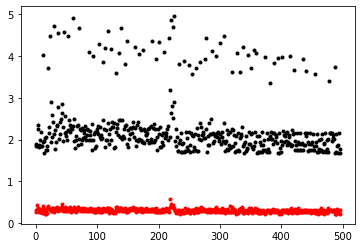

In [13]:
pp.plot(run_time_ML_listP2[3:],'.k',GmresRunTimeOriginal_2[3:],'.r')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


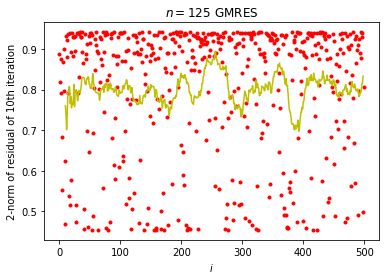

In [9]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[10:-1],AVG[10:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$n=125$ GMRES')
pp.savefig('GMRES.png')

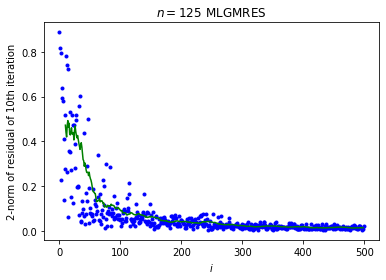

In [10]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$n=125$ MLGMRES')
pp.savefig('MLGMRES.png')

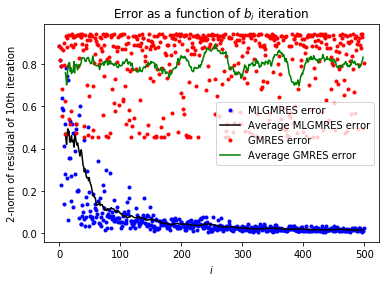

In [11]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('Error as a function of $b_i$ iteration ')
pp.legend(loc='best')
pp.savefig('Compare.png')

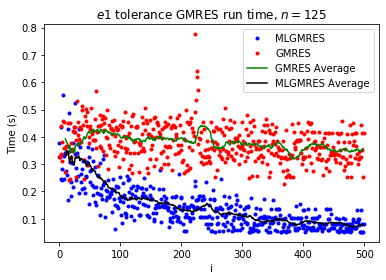

In [12]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')




pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n=125$')
pp.legend(loc='best')
pp.savefig('Runtime.png')